In [1]:
import os
import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

In [2]:
import keras
from keras import layers
import keras_cv

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io
import tensorflow as tf
import pandas as pd
import numpy as np

warnings.filterwarnings(action="ignore")
tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [3]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nKerasCV\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       keras.__version__, 
       keras_cv.__version__ , 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.16.1	CUDA False	GPU False	XLA True
Keras		 : 3.1.1
KerasCV		 : 0.8.2
Pandas		 : 1.4.1
NumPy		 : 1.24.4


In [4]:
chkp_call_loss = keras.callbacks.ModelCheckpoint(
        'checkpoint.weights.h5',
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
    )

chkp_call_accuracy = keras.callbacks.ModelCheckpoint(
        'checkpoint.weights.h5',
        monitor="accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
    )

chkp_call_val_loss = keras.callbacks.ModelCheckpoint(
        'checkpoint.weights.h5',
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
    )

chkp_call_val_accuracy = keras.callbacks.ModelCheckpoint(
        'checkpoint.weights.h5',
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
    )

IMAGE_SIZE = 512
BATCH_SIZE = 2
NUM_CLASSES = 104

backbone = keras_cv.models.ResNet50V2Backbone(input_shape=[512, 512, 3])
model = keras_cv.models.segmentation.DeepLabV3Plus(
    num_classes=NUM_CLASSES, backbone=backbone,
)

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [5]:
chkp_fichier = '/home/jovyan/model_sauvegarde/checkpoint.weights.h5'
if os.path.exists(chkp_fichier):
    if not os.path.isdir(chkp_fichier):
        model.load_weights(chkp_fichier)

In [6]:
IMAGE_SIZE = 512
def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [7]:
image_tensor = read_image('/home/jovyan/images/00000269.jpg')
prediction_mask = infer(image_tensor=image_tensor, model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [12]:
donnees = pd.read_csv('/home/jovyan/donnees/category_id.txt',sep='\t')
donnees.columns=['no','label']
colormap = list(donnees.iloc[:,0].values)+[204]
colormap = np.array(colormap).astype(np.uint8)

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        # r[idx] = colormap[l, 0]
        # g[idx] = colormap[l, 1]
        # b[idx] = colormap[l, 2]
        r[idx] = colormap[l]
        g[idx] = colormap[l]
        b[idx] = colormap[l]       
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
        axes[i].axis("off")        
    plt.show()


def plot_predictions(images_list, colormap, model, n_classes):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, n_classes)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )
    return prediction_mask,prediction_colormap


train_images = sorted(glob("/home/jovyan/images/*"))

def read_image(image_path):
    image = tf_io.read_file(image_path)
    image = tf_image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list):
    image = read_image(image_list)
    return image

def data_generator(image_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


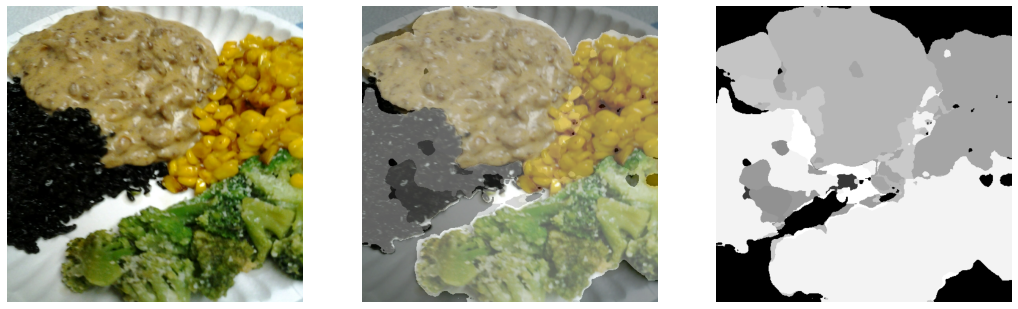

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


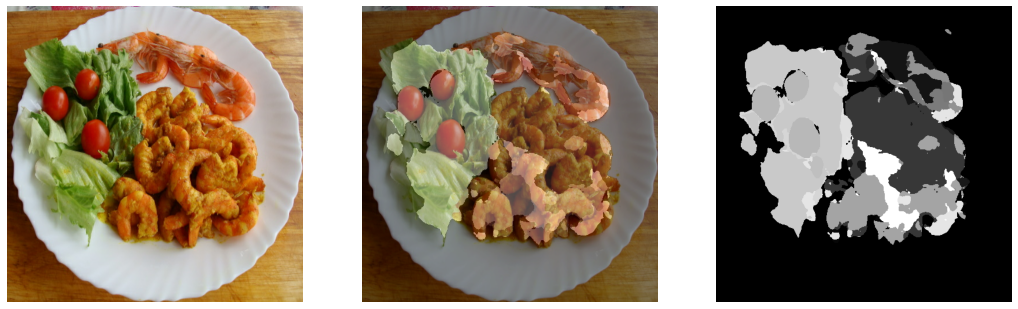

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


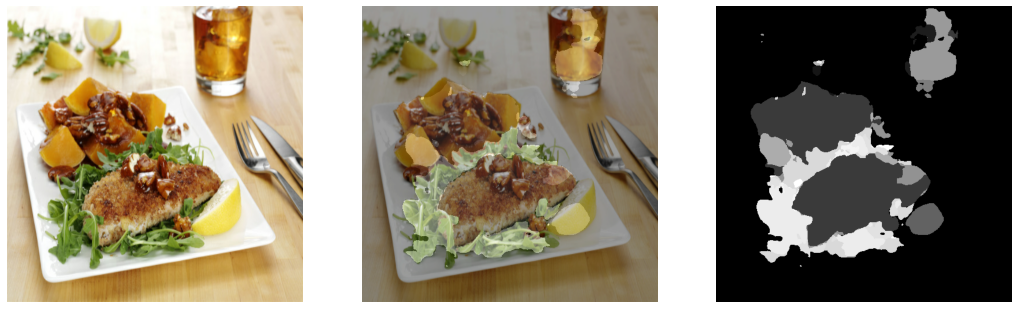

In [13]:
prediction_mask = plot_predictions(train_images, colormap, model=model, n_classes=NUM_CLASSES)